# Pendulum: Getting Started

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate();
using Altro
using TrajectoryOptimization
using RobotDynamics

  Activating environment at `~/.julia/dev/AltroTutorials/Project.toml`


## 1. Defining the Dynamics Model
The first step of setting up and solving a trajectory optimization problem is usually defining the dynamics model you want to use. All dynamics models used by TrajectoryOptimization and Altro are defined using RobotDynamics. Here we set up a dynamics model for the simple pendulum.

The first step is to create a new `struct` that is a sub-type of `RobotDynamics.AbstractModel`. In Julia, sub-typing is similar to inheritance, in that any methods that work on parent types work on the child types. Additionally, Julia will automatically find the method that matches the most specific method for the argument type(s), similar to virtual methods in C++. Therefore, by defining our new type to be a sub-type of `RobotDynamics.AbstractModel` we allow it to be used anywhere an `AbstractModel` is expected. Additionally, we're expected to define a few methods for our type to flush out the interface (similar to defining a pure virtual function in C++).

We can add any model parameters to the new `struct` we have created, such as the mass, length, friction coefficient, etc. Remember to annotate the types on all member variables.

In [3]:
struct Pendulum <: AbstractModel
    mass::Float64
    length::Float64
    b::Float64
    lc::Float64
    I::Float64
    g::Float64
end

Often we want to define a default constructor for our model that supplies default values. We'll define an *outer* constructor taking keyword arguments corresponding to our data fields. It then calls the default *inner* constructor, which expects the positional arguments for all the fields, in the order they are declared in the struct. Note that the leading semi-colon in the argument list specifies that all the following arguments are keyword arguments. Unlike Python, these *must* be supplied as keyword arguments, e.g. `Pendulum(b=0.2)`. We'll demonstrate an easier way to define default values in the next example.

In [4]:
# default constructor with default keyword arguments
function Pendulum(; mass=1.0, length=0.5, b=0.1, lc=0.5, I=0.25, g=9.81)
    Pendulum(mass, length, b, lc, I, g)  # call default "inner" constructor
end

Pendulum

Now we need to flush out the interface, which expects us to "overload" the following methods on our type:
* `RobotDynamics.state_dim(::NewModel)`
* `RobotDynamics.control_dim(::NewModel)`
* `RobotDynamics.dynamics(::NewModel, x, u, [t])`

where the `t` argument for the dynamics is optional, and can be used for time-varying dynamics. When we define these methods, we have to tell Julia that we're overloading the methods in RobotDynamics. We can do this by either 1) explicitly specifying the module (`RobotDynamics`) when defining the method, or 2) importing the method via `import RobotDynamics.MethodToOverride`. We'll show both approaches below:

In [5]:
import RobotDynamics.dynamics
# import RobotDynamics: dynamics, state_dim, control_dim (alternative with multiple imports)

# Explicitly define the module to override (recommended)
RobotDynamics.state_dim(::Pendulum) = 2
RobotDynamics.control_dim(::Pendulum) = 1

# Use the imported function (not recommended, since it isn't as clear that you're overriding an existing method)
function dynamics(p::Pendulum, x, u)
    m = p.mass * p.lc * p.lc
    xdot = [x[2], u[1]/m - p.g*sin(x[1])/p.lc - p.b*x[2]/m]
    return xdot  # this line is optional, since Julia returns the last expression, by default
end

dynamics (generic function with 21 methods)

And with that, we've defined our dynamics model!

## 2. Defining our Cost Function
We'll now define our cost function, which will be a basic quadratic cost penalizing the distance to the goal:
$$ \frac{1}{2} (x_N - \bar{x}_N)^T Q_N (x_N - \bar{x}_N) + \frac{1}{2}\sum_{k=1}^{N-1} (x_k - \bar{x}_N)^T Q (x_k - \bar{x}_N) + u_k^T R u_k $$
where $\bar{x}_N$ is the goal state.

We start be first creating an instance of our model, since it tells us our state and control dimensions. We also need to define the length of our trajectory, both in time (seconds) and the number of knot points (sample points).

In [6]:
# Create a pendulum model
model = Pendulum()

# Get the model sizes
n = state_dim(model)
m = control_dim(model)

# Define the discretization
N = 51
tf = 3.0

3.0

We can now define our cost matrices, $Q_N$, $Q$, and $R$, as well our final state $\bar{x}_N$. These are almost always diagonal, positive-definite matrices. To leverage this structure, we define them using the `Diagonal` matrix type in the `LinearAlgebra` package in the Julia standard library.

In [7]:
using LinearAlgebra

Q = 1e-3*Diagonal(ones(n))
R = 1e-3*Diagonal(ones(m))
Qf = 1e-0*Diagonal(ones(n))
xf = [pi, 0.0];  # i.e. swing up

With those defined, we now have all we need to define our cost function. We'll use the conventient [`LQRObjective`](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/cost_api.html#TrajectoryOptimization.LQRObjective) constructor in TrajectoryOptimization.jl (see docs for more details).

In [10]:
obj = LQRObjective(Q,R,Qf,xf,N);

The `Objective` object we just created holds an individual `CostFunction` for each knot point. We can extract those simply by indexing into the object, i.e. `obj[k]`. It defines methods for evaluating the cost and it's first and second-order derivatives.

## 3. Defining the Problem
With our dynamics and cost function, we're now ready to set up and solve our first trajectory optimization problem! We do this using the aptly-named `TrajectoryOptimization.Problem` type. The constructor for this objective is quite friendly and offers several different convenient forms, but you'll almost always call it as follows:

In [11]:
# Initial state
x0 = [0.0, 0.0]

# Define the problem
prob_pendulum = Problem(model, obj, xf, tf, x0=x0);

## 4. Setting the initial guess
As with all gradient-based nonlinear optimization, the initial guess is extremely important. By default, Altro (which uses iLQR for unconstrained problems like this), only accepts initial guesses for the control trajectory. We'll provide a simple guess that applies a small torque in one direction for the duration of the trajectory.

In [12]:
# Define the initial guess
U0 = [fill(0.1, m) for k = 1:N-1]

# Set the initial guess for the problem
initial_controls!(prob_pendulum, U0)

**A Note on Trajectory Representation**: Note that by default all trajectories in TrajectoryOptimization.jl are defined as vectors of (static) vectors. Don't worry about the static vectors for now, since we'll cover that in shortly. Instead of storing the trajectory as a 2D array, we avoid the overhead of slicing at runtime every time we need a state or control at a time step by defining them as separate vectors. Several methods in the API accept either vectors of vectors or 2D arrays, and `initial_controls!` is one of those. We demonstrate that below, along with an example of how to easily convert back and forth between these representations.

In [13]:
# convert from vector of vectors to 2D array
U0_mat = hcat(U0...)  # uses splatting

# pass to problem
initial_controls!(prob_pendulum, U0_mat)

# convert back to a vector of vectors
U0_vecvec = [u for u in eachcol(U0_mat)];  # uses list comprehension

**A note on methods that end with a bang!** Methods that end with a bang symbol (!) aren't more exciting than other methods, it's just Julia convention for *mutuating* functions. For example, if you want to sort a list of numbers, you can use either `sort` which returns a new array, or you can sort in place using `sort!`:

In [11]:
list = [1,5,2,4]
list_sorted = sort(list)
println("Use `sort`")
@show list_sorted
@show list
@show list_sorted === list;  # test if they point to the same place in memory
println("\nUse `sort!`")
list_sort!ed = sort!(list)
@show list_sort!ed
@show list
@show list_sort!ed === list; # test if they point to the same place in memory

Use `sort`
list_sorted = [1, 2, 4, 5]
list = [1, 5, 2, 4]
list_sorted === list = false

Use `sort!`
list_sort!ed = [1, 2, 4, 5]
list = [1, 2, 4, 5]
list_sort!ed === list = true


## 5. Creating the Solver
Now that we have a problem, complete with an initial guess, let's create our solver. It might take a few seconds the first time.

When we create the solver, it allocates a bunch of storage for all the expansions, costs, dynamics, etc. The solver object acts similarly to a `Problem` object, in that we can extract the state and contorl trajectories, query the cost, provide an initial guess, change the initial state, etc. We'll cover more of these methods as we go through later examples.

In [16]:
# Create an Altro solver for our problem
solver = ALTROSolver(prob_pendulum);

## 6. Solve the problem
We're now ready to solve our problem, and it's as easy as calling the `solve!` method. Again, it might take a few seconds the first time.

In [17]:
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 1
    Solve Time: 0.140704 (ms)

  Covergence
    Terminal Cost: 0.013817374452423623
    Terminal dJ: 4.092687180234228e-5
    Terminal gradient: 0.010103739286465803
    Solve Status: SOLVE_SUCCEEDED


Note that the `solve!` method ends with a bang symbol (!). This means that it modifies its trajectory in place. If we extract out the control vector we'll see that it's no longer the guess we provided:

In [14]:
states(solver)
controls(solver)'

1×50 adjoint(::Vector{StaticArrays.SVector{1, Float64}}) with eltype Adjoint{Float64, StaticArrays.SVector{1, Float64}}:
 [2.33418]  [2.86693]  [3.40326]  [3.91253]  …  [-0.0112322]  [-0.0188922]

So if we call the `solve!` method again, it will be using the answer as the initial guess, it now only takes 1 iteration:

In [18]:
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 1
    Solve Time: 0.113381 (ms)

  Covergence
    Terminal Cost: 0.013797611180320848
    Terminal dJ: 1.9763272102775106e-5
    Terminal gradient: 0.0069066371585198615
    Solve Status: SOLVE_SUCCEEDED


If you want to re-run the initial solve, you'll have to reset the initial guess:

In [19]:
initial_controls!(solver, U0)
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 44
    Solve Time: 2.294596 (ms)

  Covergence
    Terminal Cost: 0.013858301324225965
    Terminal dJ: 7.610875539241016e-5
    Terminal gradient: 0.014192639231066964
    Solve Status: SOLVE_SUCCEEDED


## 7. Post-processing
Now that we've solved our problem, let's extract out some information. The code block below demonstrates several different useful methods:

In [17]:
# get the solver iterations
iters = iterations(solver)

# get the state trajectory
X_sol = states(solver)

# get the control trajectory
U_sol = controls(solver)

# get the final cost
J_final = cost(solver)

# print the summary
Altro.print_summary(solver)


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 44
    Solve Time: 2.284271 (ms)

  Covergence
    Terminal Cost: 0.013858301324225965
    Terminal dJ: 7.610875539241016e-5
    Terminal gradient: 0.014192639231066964
    Solve Status: SOLVE_SUCCEEDED


If you want to extract out intermediate values, you can extract out the `SolverStats` type which containts a bunch of info logged during the solve:

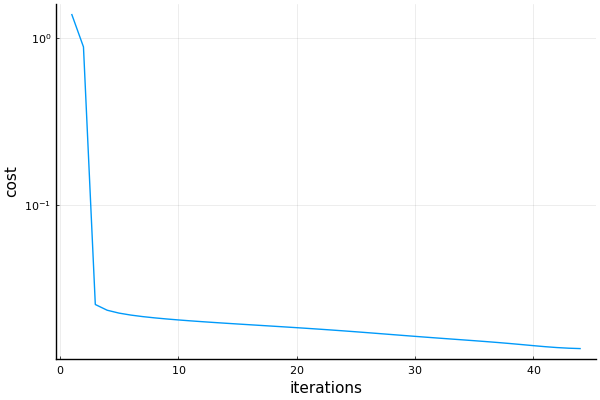

In [20]:
using Plots
pyplot()
stats = Altro.stats(solver)
plot(stats.iteration, stats.cost, yscale=:log10, xlabel="iterations", ylabel="cost", label="")

## 8. Benchmarking
We often want to get reliable timing information on our solve times, in order to get good comparisons between solves. Altro.jl provides a useful method for benchmarking the solve. Like before, we must reset the initial guess prior to calling this method. This uses BenchmarkkTools.jl to run the solve many times, and automatically resets the guess between solves.

In [21]:
# reset initial guess
initial_controls!(solver, U0)

# run the benchmark solve
benchmark = benchmark_solve!(solver)

BenchmarkTools.Trial: 
  memory estimate:  5.64 MiB
  allocs estimate:  49500
  --------------
  minimum time:     1.921 ms (0.00% GC)
  median time:      2.691 ms (28.08% GC)
  mean time:        2.499 ms (18.45% GC)
  maximum time:     3.044 ms (25.83% GC)
  --------------
  samples:          10
  evals/sample:     10

## 9. Improving Performance with Static Vectors
One of the easiest ways to get more performance is to use `StaticArrays.jl`. Let's redefine our model, cost function and problem to use static vectors and see how our performance changes:

In [23]:
using StaticArrays

# Define a new model
struct PendulumStatic <: AbstractModel
    mass::Float64
    length::Float64
    b::Float64
    lc::Float64
    I::Float64
    g::Float64
end
function PendulumStatic(; mass=1.0, length=0.5, b=0.1, lc=0.5, I=0.25, g=9.81)
    PendulumStatic(mass, length, b, lc, I, g)  # call default "inner" constructor
end

RobotDynamics.state_dim(::PendulumStatic) = 2
RobotDynamics.control_dim(::PendulumStatic) = 1

function RobotDynamics.dynamics(p::PendulumStatic, x, u)
    m = p.mass * p.lc * p.lc
    # NOTE the SA prefeix here, which creates a static array
    SA[x[2], u[1]/m - p.g*sin(x[1])/p.lc - p.b*x[2]/m]
end

# Define the Cost Function
# NOTE the use of @SVector to create static vectors
Q = 1e-3*Diagonal(@SVector ones(n))
R = 1e-3*Diagonal(@SVector ones(m))
Qf = 1e-0*Diagonal(@SVector ones(n))

# NOTE these don't actually have to be static vectors, since the problem will convert them automatically
x0_static = @SVector zeros(n)
xf_static = @SVector [pi, 0.0]  # i.e. swing up
obj_static = LQRObjective(Q,R,Qf,xf,N)

# Define the problem and solver
model_static = PendulumStatic()
prob_static = Problem(model_static, obj_static, xf_static, tf, x0=x0_static);
solver_static = ALTROSolver(prob_static);

Now let's solve it and compare the results:

In [24]:
initial_controls!(solver_static, U0);
benchmark_static = benchmark_solve!(solver_static)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     554.278 μs (0.00% GC)
  median time:      573.989 μs (0.00% GC)
  mean time:        584.076 μs (0.00% GC)
  maximum time:     674.751 μs (0.00% GC)
  --------------
  samples:          10
  evals/sample:     10

In [25]:
using BenchmarkTools
judge(median(benchmark_static), median(benchmark))

BenchmarkTools.TrialJudgement: 
  time:   -78.67% => improvement (5.00% tolerance)
  memory: -100.00% => improvement (1.00% tolerance)
